In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
sns.set_theme(palette='muted',font_scale=1.3)
plt.rcParams.update({'font.size': 20})

### Load and summarize some points in the data 

In [2]:
df = pd.read_csv('./data/train_set.csv', index_col=0)

genes_to_predict = list(df.index)
pairs_to_predict = list(pd.read_csv('./data/test_set.csv', header=None)[0])

print('Number of genes to predict = ' + str(len(genes_to_predict)))
print('Number of pairs to predict = ' + str(len(pairs_to_predict)))

Number of genes to predict = 1000
Number of pairs to predict = 50


In [3]:
s_per = [x for x in df.columns if '+ctrl' in x]
s_per = [x[:5] for x in s_per]
s_per = list(set(s_per))
s_per.sort()
print('Number of unique single perturbations in data set = ' + str(len(s_per)))

d_per = [x for x in df.columns if (('+' in x)&('ctrl' not in x))]
d_per = [x[:11] for x in d_per]
d_per = list(set(d_per))
d_per.sort()
print('Number of unique double perturbations in data set = ' + str(len(d_per)))

Number of unique single perturbations in data set = 101
Number of unique double perturbations in data set = 75


### Make prediction

In [133]:
preds = pd.DataFrame(columns=['gene', 'perturbation', 'expression'], index=range(50_000))

cols_to_avg_dict = {}
for pair in pairs_to_predict:
    # for k in range(1):
    #     pair = pairs_to_predict[0]
    g1 = pair.split('+')[0]
    g2 = pair.split('+')[1]
    # add control columns
    cols_to_average = [x for x in df.columns if (('ctrl' in x)&(len(x)<=7))]

    # add columns if either gene in the perturbation was part of a previous double perturbation
    for double in d_per:
        if ((g1 in double) | (g2 in double)):
            cols_to_add = [x for x in df.columns if double in x]
            cols_to_average.extend(cols_to_add)
    
    # add columns if either gene in the perturbation was previously sinlgy perturbed
    for single in s_per:
        if ((g1 in single) | (g2 in single)):
            cols_to_add = [x for x in df.columns if (((single+'+') in x)|(('+'+single) in x))]
            cols_to_average.extend(cols_to_add)
    cols_to_avg_dict[pair] = cols_to_average

j = 0
for i in tqdm(range(len(genes_to_predict))):
# for i in tqdm(range(1)):
    gene = genes_to_predict[i]
    for pair in pairs_to_predict:
        cols_to_average = cols_to_avg_dict[pair]    
        temp = df.loc[gene]
        temp = temp[cols_to_average]
        expression = np.mean(temp)
        preds.iloc[j] = [gene, pair, expression]
        j += 1
preds        

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 34.44it/s]


,gene,perturbation,expression
0,g0001,g0037+g0083,0.36619
1,g0001,g0083+g0605,0.38051
2,g0001,g0095+g0257,0.234398
3,g0001,g0095+g0520,0.21667
4,g0001,g0109+g0317,0.31663
...,...,...,...
49995,g1000,g0924+g0852,0.935889
49996,g1000,g0927+g0186,1.1313
49997,g1000,g0957+g0186,1.109239
49998,g1000,g0957+g0261,0.971783


In [134]:
preds = preds.sort_values(['perturbation','gene'])
preds.to_csv('./prediction/prediction.csv', index=False)
preds.to_csv('./prediction/prediction_average.csv', index=False)

### Test that I have the right order

In [127]:
template = pd.read_csv('./prediction/prediction-template.csv')
template = template[['gene', 'perturbation']]
submission = preds[['gene', 'perturbation']].reset_index(drop=True)

In [130]:
(submission == template).all()

gene            True
perturbation    True
dtype: bool

# Weighted Average

In [4]:
cols_to_avg_dict = {}
for pair in pairs_to_predict:
    # for k in range(1):
    #     pair = pairs_to_predict[0]
    g1 = pair.split('+')[0]
    g2 = pair.split('+')[1]
    # add control columns
    cols_to_average = [x for x in df.columns if (('ctrl' in x)&(len(x)<=7))]

    # add columns if either gene in the perturbation was part of a previous double perturbation
    for double in d_per:
        if ((g1 in double) | (g2 in double)):
            cols_to_add = [x for x in df.columns if double in x]
            cols_to_average.extend(cols_to_add)
    
    # add columns if either gene in the perturbation was previously sinlgy perturbed
    for single in s_per:
        if ((g1 in single) | (g2 in single)):
            cols_to_add = [x for x in df.columns if (((single+'+') in x)|(('+'+single) in x))]
            cols_to_average.extend(cols_to_add)
    cols_to_avg_dict[pair] = cols_to_average

In [8]:
def make_weights(cols_to_average):
    weights = np.ones(len(cols_to_average))
    for i, col in enumerate(cols_to_average):
        if '+g' in col:
            weights[i] = 0.25
    return weights

In [10]:
preds = pd.DataFrame(columns=['gene', 'perturbation', 'expression'], index=range(50_000))

j = 0
for i in tqdm(range(len(genes_to_predict))):
# for i in tqdm(range(1)):
    gene = genes_to_predict[i]
    for pair in pairs_to_predict:
        cols_to_average = cols_to_avg_dict[pair]    
        weights = make_weights(cols_to_average)
        
        temp = df.loc[gene]
        temp = temp[cols_to_average]
        expression = np.average(temp, weights=weights)
        preds.iloc[j] = [gene, pair, expression]
        j += 1
preds     

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 52.01it/s]


,gene,perturbation,expression
0,g0001,g0037+g0083,0.343442
1,g0001,g0083+g0605,0.344474
2,g0001,g0095+g0257,0.255192
3,g0001,g0095+g0520,0.229867
4,g0001,g0109+g0317,0.327343
...,...,...,...
49995,g1000,g0924+g0852,1.002306
49996,g1000,g0927+g0186,1.170681
49997,g1000,g0957+g0186,1.13811
49998,g1000,g0957+g0261,0.986197


In [11]:
preds = preds.sort_values(['perturbation','gene'])
preds.to_csv('./prediction/prediction.csv', index=False)
preds.to_csv('./prediction/prediction_weighted_average.csv', index=False)

### compare to previous submissions

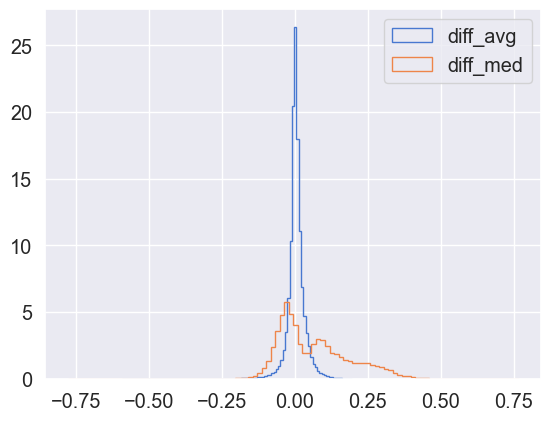

In [14]:
pred_avg = pd.read_csv('./prediction/prediction_average.csv')
pred_median = pd.read_csv('./prediction/prediction_median.csv')
pred_wavg = pd.read_csv('./prediction/prediction_weighted_average.csv')

diff_avg = pred_wavg['expression'] - pred_avg['expression']
diff_med = pred_wavg['expression'] - pred_median['expression']

nbins = 100
plt.hist(diff_avg, bins=nbins, histtype='step', density=True, label='diff_avg')
plt.hist(diff_med, bins=nbins, histtype='step', density=True, label='diff_med')
plt.legend();

In [15]:
rmsd_avg = np.sqrt(np.mean(diff_avg**2))
rmsd_med = np.sqrt(np.mean(diff_med**2))

print('RMSD wavg-avg = ' + str(rmsd_avg))
print('RMSD wavg-med = ' + str(rmsd_med))

RMSD wavg-avg = 0.03147970314897869
RMSD wavg-med = 0.13731361581671897
